# **Notebook Esame AVRC (Parte 1)**

## Loading Modules

In [ ]:
from pathlib import Path

import networkx as nx
import networkx.algorithms as nxa
import networkx.classes.function as nxfunc

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
from matplotlib import ticker

from collections import Counter
from operator import itemgetter
from netgraph import Graph
from dataviz import utility as dviz

import scipy
import scipy.stats as scistats

# Cambiare solo l'import per cambiare la 'libreria' di colormaps
from palettable.scientific.sequential import Bamako_3 as palette

import community

## reproducibility
RND_SEED = 123456

## dataviz setup
FONT_DIR = "./dataviz/fonts"
font_files = font_manager.findSystemFonts(fontpaths=FONT_DIR)

for font_file in font_files:
   font_manager.fontManager.addfont(font_file)

MATPLOTLIB_THEME_FILE = "./dataviz/mpl_theme.mplstyle"
plt.style.use(MATPLOTLIB_THEME_FILE)

theme = {
   "colors": {
      "avg_line": "blue",
      "avg_line_alpha": 0.5
   },
   "sizes": {
      "box_width": 0.3
   }}

%matplotlib inline

## Utility Variables

In [ ]:
##
# Minimo e massimo coefficient per assortatività/disassortatività
#
ass_min_coeff = 0.1 # Limite minimo per dire che la funzione sta crescendo (assortativa)
disass_min_coeff = -0.1 # Limite minimo per dire che la funzione sta decrescendo (disassortativa)
##

## 
# NetworkX Plot Setup
#
# Generica per quando si fa la draw della rete
network_options = {"edgecolors": "tab:gray", "node_size": 600, "font_color": "whitesmoke", "font_size": 18, "alpha": 0.8}
# Più specifici quando facciamo i draw dei singoli componenti
node_options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
edge_options = {"alpha": 0.4}
label_options = {"font_color": "whitesmoke", "font_size": 20}
##

# Informazioni sulla rete usata (colonia/threshold ecc ecc)
network_data = {
    "path": "ants_proximity",
    "prefix": "ant_mersch_",
    "chosen_colony": "col2",
    "cut_threshold":  10, #8 sembra essere un buon valore, tiene forma della distribuzione di densità simile e taglia abbastanza
    "n_sims": 10, # number of random simulations
    "omega_n_sims":10 # numbero of random simulation for small world omega coefficient
}

# dictionary to store figures and then preprare for export
figures = {}

# 1.&nbsp;Network Analysis

## The Network

#### **Network Description:**
Ecological Network: (specie abitanti in un ecosistema + modellazione)

Descrivere la faccenda della riduzione degli archi nella rete (che abbiamo rimosso x ridurre la densità della rete)
Descrivendola come "pulizia" per le possibili iterazioni "false-positive" fra formiche di differenti ranghi. (anche se sappiamo bene non essere proprio per quello)

-> 

IN NETWORK DEGREE CORRELATION, CONTROLALRE SE USARE COME VALORE PER K IL PAERSON OPPURE IL VALORE DEL FIT DELLA RETTA

Misura l'efficienza dello scambio di informazioni nella rete

https://networkx.org/documentation/stable/reference/algorithms/efficiency_measures.html

In [ ]:
def read_colonies_files(path, prefix, exclude_colony_ids=[], timesteps_span=(-math.inf,math.inf)):
    colonies = {}
    network_files = Path(path).glob(f"{prefix}*")

    for file_path in sorted(network_files): # read sorted files to preserve the right temporal sequence  
        colony_id, timestep = file_path.stem[len(prefix):].split("_")[0:2] # extract colony number and timestep

        if colony_id not in exclude_colony_ids:
            timestep_number = int(timestep[3:]) # extract int representation discarding "day" prefix
            if timesteps_span[0] <= timestep_number <= timesteps_span[1]:
                if colony_id in colonies:
                    timesteps_colony = colonies[colony_id]
                    network = nx.read_graphml(file_path)
                    timesteps_colony.append(network)
                else: # first time step
                    colonies[colony_id] = [nx.read_graphml(file_path)]

    return colonies

In [4]:
# Caricamento delle reti
colonies = read_colonies_files(network_data["path"], network_data["prefix"], exclude_colony_ids=['col1','col3','col4','col5','col6'])

L'intero dataset contiene 6 colonie. Ognuna di queste contiene 41 grafi, uno per ogni giorno di osservazione della colonia. La colonia 6 è l'unica a contentere 39 grafi (39 giorni di osservazione).

Dunque ogni colonia è rappresentata da un **grafo temporale**. La rapprasentazione utilizzata per il grafo temporale è quella comunenemente chiamata in letteratura *Snapshot*:

$$
\mathcal{G} = \{G(t_1), G(t_2), \ldots, G(t_{max})\}
$$

O in modo equivalente utilizzando le matrici di adicenza $A_{ijt}$ indica un evento all'istante $t$ tra il nodo $i$ e $j$. In questo modo $\mathcal{A}$ consiste in un **tensore** di ordine 3.

In [5]:
# Prendo solo la colonia scelta
Gs = colonies[network_data["chosen_colony"]]
print (f"# di snapshots: {len(Gs)}")

# di snapshots: 41


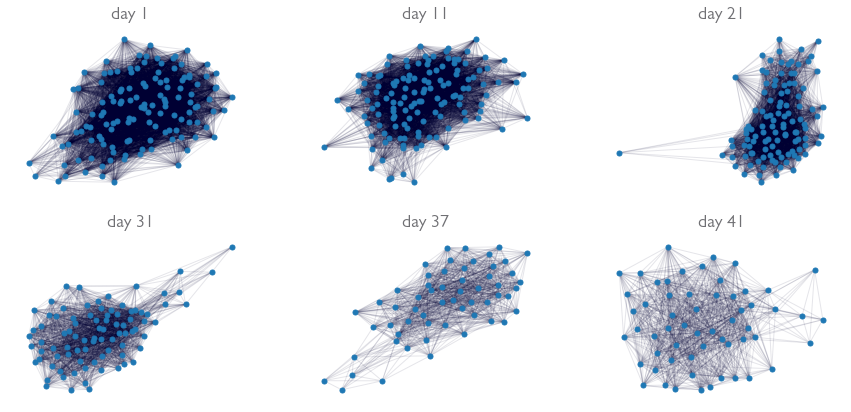

In [6]:
fig, axes = plt.subplots(2,3, figsize=(15,7))
times = np.quantile(np.arange(0,41), q=[0, 0.25, 0.5, 0.75, 0.9, 1.0], interpolation='nearest')
for ax, time in zip(axes.ravel(), times):
    layout = nx.spring_layout(Gs[time],seed=RND_SEED)
    nx.draw(Gs[time], pos=layout, ax =ax, node_size=25, edge_color=(0,0,0.2,0.1))
    ax.set_title(f"day {time+1}")


figures['temporal_snapshots'] = fig

## Plot distribuzione durata vita delle formiche

Attenzione qui con vita s'intende il lifespan relativo al tempo di rimanza all'interno della colonia. La "vera" età della formica, in senso assoluto (giorni dalla sua nascita), è presente come attributo.

In [7]:
import matplotlib as mpl

def compute_ants_lifespan(network_snapshots):
    ants_life_span = {}
    for day, snapshot in enumerate(network_snapshots,start=1):
        for ant in snapshot.nodes:
            if ant in ants_life_span:
                first, last = ants_life_span[ant]
                ants_life_span[ant] = (first, last + 1)
            else:
                ants_life_span[ant] = (day, day)
    return ants_life_span


def plot_lifespan(ants_lifespan, ax, groupby_lifespan=True, percentage=True):

    last_days = np.array([last for first, last in ants_lifespan.values()])
    idx_sorted = np.argsort(last_days)[::-1]
    last_days = last_days[idx_sorted]
    
    
    if groupby_lifespan:
        lifespans = np.unique(last_days)

        n_ants = len(ants_lifespan)
        counts = np.bincount(last_days)[lifespans]
        
        population_survivals = np.roll(counts.sum() - counts.cumsum(), 1)
        population_survivals[0] = counts.sum()
        

        ## sort in descendin order
        lifespans = lifespans[::-1]
        population_survivals = population_survivals[::-1] 

        if percentage:
            population_survivals = population_survivals / counts.sum()
            labels = [f"{surv:0.1%} up to \n{day} days" for surv, day in zip(population_survivals, lifespans)]
        else:
            labels = [f"{surv} up to \n{day} days" for surv, day in zip(population_survivals, lifespans)]

        bars = np.arange(len(lifespans))
        hbars=ax.barh(bars, lifespans -1, left=1, height=0.4) # -1 since we start from left=1
        ax.bar_label(hbars, labels=labels, label_type='edge', padding=5.0)
        ax.set_yticklabels([])
    else:
        lifespans = last_days # just a trick to reuse code
        
        ants_ids = np.array([ant for ant in ants_lifespan.keys()])
        ants_ids = ants_ids[idx_sorted]
        labels = ants_ids
        
        bars = np.arange(len(lifespans))
        ax.barh(bars, lifespans -1 , tick_label=labels, left=1, height=0.4)
                   
    days_ticks = np.unique(last_days)
    days_ticks = np.insert(days_ticks,0,1) # force day 1
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(days_ticks))

    ax.set(xlabel='Survival (days)', title='Colony Survival over Time')
    



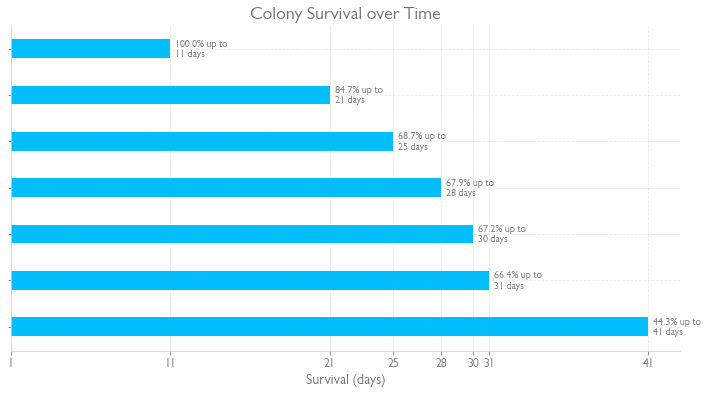

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ants_lifespan = compute_ants_lifespan(Gs)
plot_lifespan(ants_lifespan, ax=ax)

figures['colony_survival_time'] = fig

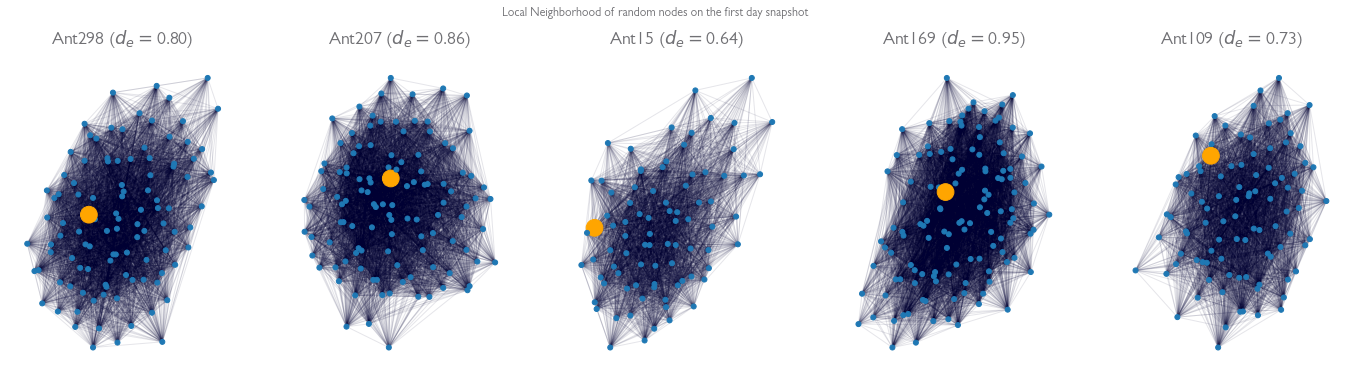

In [9]:
def highlight_nodes(G, nodes, color=(0.1,0.5,0.9,1.0), default_size=25):
    color_map = []
    sizes = []

    for node in G.nodes():
        if node in nodes:
            color_map.append('orange')
            sizes.append(default_size ** 1.75)

        else:
            color_map.append('#1f78b4')
            sizes.append(default_size)
    
    return color_map, sizes
    
n_nodes= 5
fig, axes = plt.subplots(1,n_nodes, figsize=(24,6))
random_nodes = np.random.choice(Gs[0].nodes(), size=n_nodes, replace=False)

for node, ax in zip(random_nodes, axes.ravel()):
    local = nx.generators.ego.ego_graph(Gs[0], node)
    layout = nx.spring_layout(local,seed=RND_SEED)
    colors, sizes = highlight_nodes(local, [node])
    nx.draw(local, pos=layout, edge_color=(0,0,0.2,0.1), ax=ax, node_color=colors, node_size=sizes)
    local_over_total = len(local.nodes) / len(Gs[0].nodes) # proportion of local nodes of the ego subgraph wrt all nodes of the entire graph
    ax.set_title(f"{node} ($d_e=${local_over_total:0.2f})")
    print() 

fig.suptitle("Local Neighborhood of random nodes on the first day snapshot")

figures['random_nodes_neighbors'] = fig

Ogni snapshot $G(t)$ con $t=1, \ldots, 41$, è un **grafo pesato indiretto**. L'edge tra due nodi, rappresenta l'interazione tra due formiche durante il periodo di osservazione. Il peso sull'edge indica il **numero di interazioni** in un singolo giorno di osservazione. Per la definizione di "interazione" si rimanda alla relazione o al paper originale.

In [10]:
G_network = Gs[0]
network_info = {"is_g_connected": nx.is_connected(G_network),
                "is_g_directed": nx.is_directed(G_network),
                "n_nodes": len(G_network.nodes()),
                "n_edges": len(G_network.edges())}

def show_basic_info(network_info):
    print(f"Network with {network_info['n_nodes']} nodes and {network_info['n_edges']} edges\n")
    print("Is G connected?", network_info["is_g_connected"])
    print("Is G Directed?", network_info["is_g_directed"])

show_basic_info(network_info)

Network with 131 nodes and 6591 edges

Is G connected? True
Is G Directed? False


## Density &amp; Sparsification

Qualitativamente, dai plot precedenti (sopratutto quello locale) capiamo che la densità nei vari snapshots è elevata. Procediamo quantitativamente

In [11]:
def global_treshold_sparsification(G, threshold, attribute='weight'):
    sparsified = G.copy()
    sparsified.remove_edges_from([(n1, n2) for n1, n2, w in sparsified.edges(data=attribute) if w < threshold])
    return sparsified


def plot_densities(densities, cut_densities, ax, *mpl_args, **mpl_kwargs):
    timer = np.arange(1, len(densities)+1)
    ax.plot(timer, densities, label="before", **mpl_kwargs)
    ax.plot(timer, cut_densities, label="after", **mpl_kwargs)
    ax.set(xlabel="Time (days)", ylabel="Density", title="Density over Time")


def mean_of_means_degree(networks):
    """Compute avg over time of avg mean. Each sample mean is the avg degree 
       of a single snapshot network. Samples size is the n of nodes"""
    means = []
    sizes = []
    stds = []
    for network in networks:
        degrees = [d for n,d in network.degree()]
        means.append(np.array(degrees).mean()) #sample mean
        stds.append(np.array(degrees).std())
        sizes.append(len(degrees)) #sample size
    # Average
    mean_of_means = np.average(means,weights=sizes)
    std = np.sqrt((np.array(stds)**2/len(sizes)).sum())
    return mean_of_means, std

In [12]:
# Lista densità
densities = []
# Lista densità della rete "ridotta"
cut_densities = []
# Lista reti ridotte (utilizzabili dopo)
Gs_cut = []

threshold =  network_data["cut_threshold"]
for snapshot in Gs:
    densities.append(nxfunc.density(snapshot))
    # Riduzione del numero di archi
    sparsified = global_treshold_sparsification(snapshot, threshold)
    cut_densities.append(nxfunc.density(sparsified))
    Gs_cut.append(sparsified)

densities = np.array(densities)
cut_densities = np.array(cut_densities)

No handles with labels found to put in legend.


Avg density over time: 0.64+-0.06


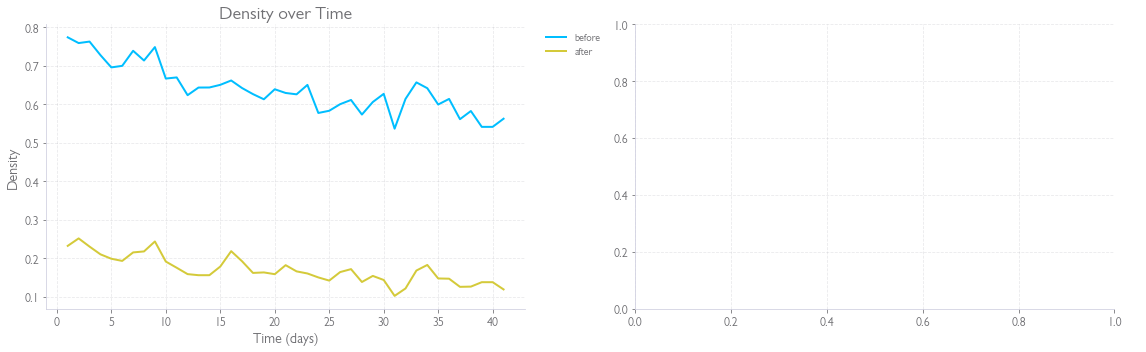

In [13]:
fig, axes = plt.subplots(1,2,figsize=(16,5))
plot_densities(densities, cut_densities, axes[0])

#axes[1].hist([densities, cut_densities], bins=20, range=(0.,1.), label=['before', 'after'])
#axes[1].set(xlabel="Density", ylabel="# Days", title="Density Distribution")

dviz.add_legend(fig,axes)

print(f"Avg density over time: {densities.mean():0.2f}+-{densities.std():0.2f}")

figures['temporal_network_density_sparsification'] = fig

In [14]:
avg_degree_before, _ = mean_of_means_degree(Gs) # avg of avg degree over time (before)
avg_degree_after, _ = mean_of_means_degree(Gs_cut) # # avg of avg degree over time (after)
avg_degree_ratio = avg_degree_after / avg_degree_before 
print(f"Avg degree ratio (after/before): {avg_degree_ratio*100:.1f}%")

Avg degree ratio (after/before): 27.8%


dai plot precedenti emergono 2 osservazioni principali:
* La distribuzione di densità è asimetrica e in tutti i 41 giorni i valori sono $>0.5$  con media $0.64 \pm 0.06$ 
* Si può notare un **trend decrescente** sulla densità. La riduzione di densità, e quindi di interazioni, è imputabile principalmente a due fattori: morte di alcune formiche o tag di tracciamento perso nel movimento della formica e quindi rimosso. 

Per limitare l'impatto della densità sulle successive operazioni, abbiamo deciso di ridurre il numero di connessioni utilizzando un processo di **sparsificazione**. Le motivazioni sono di carattere differente:
* **Computazionale**: la maggiorparte degli algoritmi di NA hanno pessime prestazioni su grafi altamente connessi. Dunque la sparsificazione aiuta a ridurre la complessità computazionale.
* **Robustezza Sperimentale**: il processo di "interaction detection" eseguito dagli autori può produrre interazioni false positive, dunque ci è sembrato naturale eliminare tutte quelle interazioni la cui frequenza è minore di una certo threshold, in quanto è naturale pensare ad esse come a "rumore". Questa scelta è dettata anche dal punto di vista dei pattern d'interazione delle formiche "simil random-walk", dunque molte 

Il meccanismo di sparsificazione utilizzato è molto semplice è prevede l'eliminazione delle connessioni utilizzando una **soglia globale** $T$ definita a priori.

$$
G'_t(N',L') \quad \text{con} \quad N' = N \quad L'=\{(u,v,w)\in L | w >= T \}  
$$

L'operazione di sparsificazione potrebbe comportare l'alterazione delle caratteristiche strutturali della rete. Per verificarlo procediamo comparando la degree distribution della rete prima e dopo la sparsificazione utilizzando il "goodness of fit" *test di Kolmogorov-Smirnoff*.

Attenzione! Il test è stato eseguito su un singolo snapshot, nello specifico il primo, in quanto è la rete più densamente connessa rispetto i restanti istanti temporali, dunque la migliore su cui valutare l'impatto della sparsificazione.

In [15]:
# 1. choose a snapshot
snapshot = Gs[0]
snapshot_cut = Gs_cut[0] 
# 2. compute the empirical degree distributions before and after the sparsification:
degrees = np.array([degree for (_, degree) in snapshot.degree()])
degrees_cut = np.array([degree for (_, degree) in snapshot_cut.degree()])
# 3. run a two sample KS test
# 4. assess the statistical significance

significance = 0.05

stat, pvalue = scistats.ks_2samp(degrees,degrees_cut)

pvalue < significance # if true reject the null hypothesis => distribs are stastically different

True

Sia dal punto di vista qualitativo (plot precedente) che quantitavo (KS test) è chiaro che la procedura di sparsificazione non permette di preservare la degree distribution. Procediamo comunque nell'analisi consapevoli di questa approssimazione. 

/home/prf/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


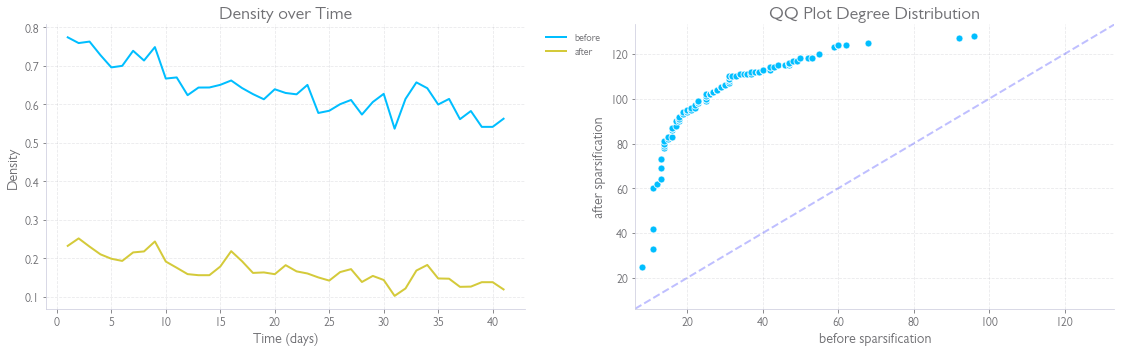

In [16]:
from statsmodels.graphics.gofplots import qqplot_2samples

fig = qqplot_2samples(np.array(degrees), np.array(degrees_cut), xlabel='before sparsification', ylabel='after sparsification', line='45', ax=axes[1])

axes[1].set_title('QQ Plot Degree Distribution')
axes[1].lines[1].set_linestyle('--')
axes[1].lines[1].set_color((0,0,1,0.25))

axes[1].lines[0].set_marker('o')
fig.axes[1].lines[0].set_markerfacecolor('#00BEFF')
fig.axes[1].lines[0].set_markeredgecolor((1,1,1,0.8))


figures['sparsification_density_qqplot'] = fig

fig

## Time Aggregation


Per procedere ad un'analisi della rete statica procediamo ad aggregare le informazioni temporali dei vari snapshot. Dato che ogni link rappresenta la frequenza d'interazione tra due formiche in un singolo giorno di osservazione, è naturale ottenere una rete che descrive le interazioni complessive semplicemente sommando le interazioni nei singoli giorni:

Sia $\mathcal{A}$ il tensore di dimensione $N\times N \times T_{max}$ che descrive la rete temporale. Otteniamo la rete aggregata $\tilde{\mathcal{A}}$ di dimensione $N\times N$ come segue:

$$
A_{ij} = \sum_{t=1}^{T_{max}} A_{ijt}
$$

$\tilde{\mathcal{A}}$ rappresenta una vista complessiva del "sistema colonia", risultando un'approssimazione in quanto eliminiamo le informazioni associate alla dimensione temporale. 

In [17]:
def make_aggregated_network(network_snapshots):
    agg_dict =  nx.to_dict_of_dicts(network_snapshots[0].copy())
    snapshots = network_snapshots[1:]
    for snapshot in snapshots: # loop trough snapshot's time
        snapshot_dict = nx.to_dict_of_dicts(snapshot.copy())
        for ant in snapshot_dict: # loop trough ants
            for neigh in snapshot_dict[ant]: # loop trough ant's neighobours
                if neigh in agg_dict[ant]:
                    agg_dict[ant][neigh]['weight'] += snapshot_dict[ant][neigh]['weight'] # sum up weights

    aggregated_network = nx.from_dict_of_dicts(agg_dict)
    ## imposto dizionari ai nodi
    for node_name in aggregated_network.nodes:
        node_snap = snapshots[0].nodes[node_name]
        # Se non ho elementi nel dizionario passo al prossimo passo
        if len(node_snap) == 0:
            continue
        node = aggregated_network.nodes[node_name]
        for key in node_snap.keys():
            node[key] = node_snap[key]
            #nxa.set_node_attributes(aggregated_network, node_snap[key], node)
    ##
    return aggregated_network

##
agg_network = make_aggregated_network(Gs_cut)

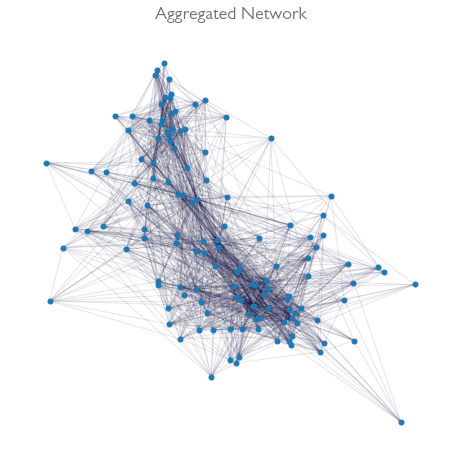

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

layout = nx.spring_layout(agg_network)#,seed=RND_SEED)
nx.draw(agg_network, pos=layout, ax =ax, node_size=25, edge_color=(0,0,0.2,0.1))

ax.set_title("Aggregated Network")

figures['aggregated_network'] = fig

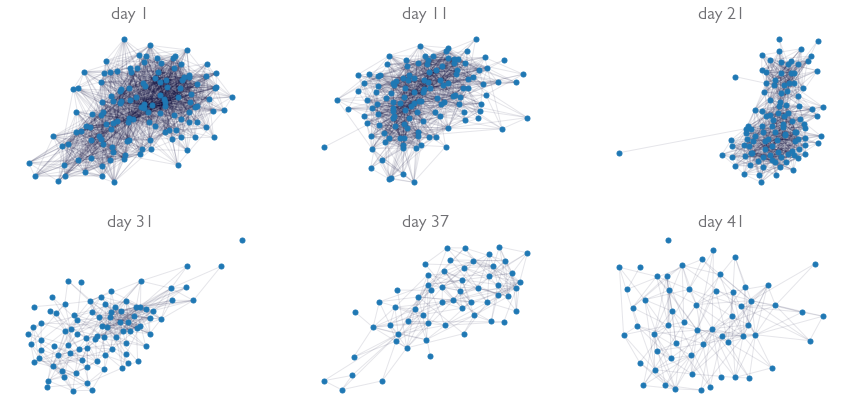

In [19]:
fig, axes = plt.subplots(2,3, figsize=(15,7))
times = np.quantile(np.arange(0,41), q=[0, 0.25, 0.5, 0.75, 0.9, 1.0], interpolation='nearest')
for ax, time in zip(axes.ravel(), times):
    layout = nx.spring_layout(Gs[time],seed=RND_SEED)
    nx.draw(Gs_cut[time], pos=layout, ax =ax, node_size=25, edge_color=(0,0,0.2,0.1))
    ax.set_title(f"day {time+1}")


figures['temporal_sparsified_snapshots'] = fig

## Utility Network Informations

This section will contain usefull infos about the network so we calculate it once

In [21]:
# IMPOSTO LA RETE CHE VERRà USATA X LE STATS DA ORA IN POI COME LA PRIMA RETE (ISTANTE 0)
# DA CAMBIARE SE VOGLIAMO MOSTRARE I VARI RISULTATI GUARDANDO I QUANTILI (prima, 33%, 66%, fine)
G_network = agg_network

In [22]:
network_info = {"is_g_connected": nx.is_connected(G_network),
                "is_g_directed": nx.is_directed(G_network),
                "n_nodes": len(G_network.nodes()),
                "n_edges": len(G_network.edges())}

def show_basic_info(network_info):
    print(f"Network with {network_info['n_nodes']} nodes and {network_info['n_edges']} edges\n")
    print("Is G connected?", network_info["is_g_connected"])
    print("Is G Directed?", network_info["is_g_directed"])

show_basic_info(network_info)

Network with 131 nodes and 1978 edges

Is G connected? True
Is G Directed? False


## Degree Distribution

Analizziamo di seguito la degree distribution.<br>
Intuitivamente, dalle osservazioni precedenti capiamo che la rete in questione difficilmente è ben rappresentata da un modello scale-free.<br>
Procediamo comunque al fit della degree distribution con alcune distribuzioni teoriche.

In [23]:
def plot_degree_distribution(graph,ax, n_bins=50, log_scale=(False, True), strength_degree=False, with_stats=False, density=False, *mpl_args, **mpl_kwargs):
  if strength_degree:
    degs = np.array([d for n,d in  graph.degree(weight='weight')]) # collect strength degree sequence
    ax.set_title("Strength Distribution")
    dviz.set_axis(ax, "Strength", "# of nodes", log_scale)
  else:
    degs = np.array([d for n,d in  graph.degree()]) # collect degree sequence
    ax.set_title("Degree Distribution")
    dviz.set_axis(ax, "Degree", "# of nodes", log_scale)

  
 
  if density: # show normalized distribution and KDE
    freqs, bins, _= ax.hist(degs, bins=n_bins, density=True)
    sns.kdeplot(degs, ax = ax, bw_adjust=0.75, color='blue', alpha=0.25)
    ax.set_ylabel("P(k)")
  else:
    freqs, bins, _ = ax.hist(degs, bins=n_bins)

  if with_stats:
    nodes = np.array([n for n,d in  graph.degree()]) # collect degree sequence
    max_node = nodes[np.argmax(degs)]
    min_node = nodes[np.argmin(degs)]

    stats = {'mean': degs.mean(), 'std': degs.std(), 
             'min': degs.min(), 'median': np.median(degs), 'max': degs.max(),
             'min_node': min_node, 'max_node': max_node}

    # avg and median degree vertical lines
    ax.axvline(stats['mean'], linestyle='--', color="red", alpha=theme['colors']["avg_line_alpha"], label="Average")
    ax.axvline(stats['median'], linestyle='--', color="blue", alpha=theme['colors']["avg_line_alpha"], label="Median")
    return bins, freqs, stats

  return bins, freqs

# Code to check for every node if their degree is less than the avg degree of their neighbors, if this is true then
# the friendship paradox hold.
def friendship_paradox_percent(G):
  paradox_hold = 0
  for node, avg_neigh_deg in nxa.assortativity.average_neighbor_degree(G).items():
    if avg_neigh_deg > G.degree(node):
      paradox_hold += 1
  # Ritorno la percentuale fra i nodi che rispettano la friendship paradox ed il numero totale di nodi nella rete
  return (paradox_hold / len(G.nodes)) * 100


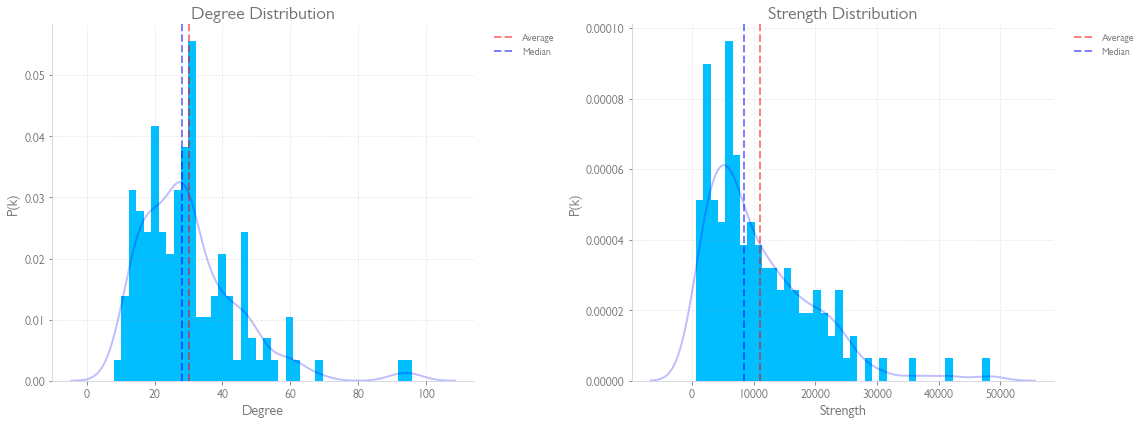

In [24]:
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize=(16,6))
k,kf,stats  = plot_degree_distribution(G_network, axes[0], n_bins=40, log_scale=(False, False), with_stats=True, density=True)
s,s, stats_weighted = plot_degree_distribution(G_network, axes[1], n_bins=40, strength_degree=True, log_scale=(False, False), density=True, with_stats=True)
dviz.add_legend(fig, axes, on_fig=True)

figures['aggrgated_degree_distribution'] = fig

In [25]:
fpp = friendship_paradox_percent(G_network)

print(f"Network Average Degree: {stats['mean']:0.2f} +- {stats['std']:0.2f}")
print(f"Node with max degree: {stats['max_node']}, max Degree: {stats['max']}")
print(f"Node with min degree: {stats['min_node']}, min Degree: {stats['min']}")
print(f"Friendship paradox holds for: {fpp:.1f} % of nodes in the network")

Network Average Degree: 30.20 +- 14.77
Node with max degree: Ant191, max Degree: 96
Node with min degree: Ant324, min Degree: 8
Friendship paradox holds for: 74.0 % of nodes in the network


In [26]:
fpp = friendship_paradox_percent(G_network)

print(f"Network Average Strength: {stats_weighted['mean']:0.2f} +- {stats_weighted['std']:0.2f}")
print(f"Node with max strength: {stats_weighted['max_node']}, max Degree: {stats_weighted['max']}")
print(f"Node with min strength: {stats_weighted['min_node']}, min Degree: {stats_weighted['min']}")
print(f"Friendship paradox holds for: {fpp:.1f} % of nodes in the network")

Network Average Strength: 10988.02 +- 8612.02
Node with max strength: Ant650, max Degree: 48225
Node with min strength: Ant647, min Degree: 630
Friendship paradox holds for: 74.0 % of nodes in the network


Il plot ottenuto, non in scala logaritmica dato che l'estensione del grado e delle frequenze non supera 2 ordini di grandezza, non suggerisce una distribuzione "heavy-tail". 
Dato che l'esponente caratterisco per le scale-free network è $2\leq\gamma\leq3$. Proviamo ad eseguire un test KS goodness of fit tra la degree distribution e una power law.


In [27]:
degrees = [d for n,d in G_network.degree()]
significance_level = 0.05
gammas = np.arange(2.0,3.0,0.1)
null_rejections = []
for gamma in gammas:
    stat, pvalue = scistats.kstest(degrees, scistats.powerlaw(a=gamma).cdf)
    null_rejections.append(pvalue < significance_level)

success = np.array(null_rejections).sum() / len(null_rejections)
print(f"{success:.0%}")

100%


In tutti e tre i casi, $\gamma=2.0$, $\gamma=2.5$ e $\gamma=3.0$, possiamo rifiutare la null hypothesis in favore dell'alternativa. Dunque possiamo confermare l'intuizione: la degree distribution non segue una powerlaw. 

## Network Distances

Questo è un commento sulla sezione

In [28]:
# APL = sum_{i,j} lunghezza_path_{i,j} / (g_n_nodi*g_n_nodi-1), se la rete è non diretta bisogna moltiplicare per 2 avendo il doppio di connessioni
def compute_network_apl(G):
  """"Compute the network average path length (APL). This is just a wrapper function of nx.average_shortest_path_length
      that extends the behaviour for graph with disconnected components.
      For this kind of graph, this function return the avarage of the components' APL
  """ 
  APL = 0
  if nx.is_connected(G):
    APL = nx.average_shortest_path_length(G)
  else:
    conn_comps = 0
    for conn_comp in nx.connected_components(G): # loop trough connected components' induced subgraphs
      sub_graph = G.subgraph(conn_comp)
      APL += nx.average_shortest_path_length(sub_graph)
      conn_comps += 1
    # Fuori dal for
    APL /= conn_comps #avg APL
  return APL

def shortest_path_length_distribution(G):
  """ Compute the distribution of the shortest path lengths between all nodes. 
      Return (list[int],list[int]) of shortest path lengths and their associated frequencies"""
  counter = Counter()
  # count frequency of shortest path length between all node pairs
  for target, shortest_paths in nx.all_pairs_shortest_path_length(G):
    counter.update(v for k,v in shortest_paths.items())

  freqs =[]
  shortest_path_lengths = []
  # unpack counter list of tuples into two lists
  for spl, freq in counter.items():
      shortest_path_lengths.append(spl)
      freqs.append(freq)

  return shortest_path_lengths, freqs

def plot_path_length_distribution(G, figure, ax, with_apl=True, log_scales=(False,False), *mpl_args, **mpl_kwargs):
  """Plot path lengths distribution, optionally with the APL.
     mpl_args and mpl_kwargs are passed to matplotlib bar plot function"""

  apl = compute_network_apl(G)
  path_lengths, freqs = shortest_path_length_distribution(G)

  ax.axvline(apl, linestyle='--', color=theme['colors']["avg_line"], alpha=theme['colors']["avg_line_alpha"], label="Average")
  ax.bar(path_lengths, freqs, **mpl_kwargs)

  if log_scales[0]:
    ax.set_xscale("log")
  if log_scales[1]:
    ax.set_yscale("log")

  ax.set(xticks=path_lengths, xlabel="Shortest Path Length", ylabel="# Paths", title="Distance Distribution")

## Network Clustering

Questo è un commento sulla sezione

In [29]:
def plot_network_clustering(G, ax1, ax2, print_labels=True, with_network=True, *mpl_args, **mpl_kwargs):
  lcc = nx.clustering(G)
  # Average -> media dei coefficienti di clustering dei vari nodi
  avg_lcc = float("{:0.3f}".format(sum(lcc.values()) / float(len(G.nodes))))
  median_lcc = np.median(list(lcc.values()))
  # ax1
  if with_network:
    cmap = palette.mpl_colormap
    norm = plt.Normalize(0, max(lcc.values()))
    node_colors = [cmap(norm(lcc[node])) for node in G.nodes]
    layout = nx.spring_layout(agg_network,seed=RND_SEED)
    nx.draw_spring(agg_network, ax =ax1, node_size=150, edge_color=(0,0,0.2,0.05), node_color=node_colors)
    #nx.draw_spring(G, node_color=node_colors, with_labels=print_labels, ax=ax1, **network_options)
    fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering Coefficient', shrink=0.95, ax=ax1, **mpl_kwargs)
  # ax2
  ax2.hist(lcc.values(), bins=20, **mpl_kwargs)
  ax2.axvline(avg_lcc, linestyle='--', color="red", alpha=theme['colors']["avg_line_alpha"], label="Average")
  ax2.axvline(median_lcc, linestyle='--', color="blue", alpha=theme['colors']["avg_line_alpha"], label="Median")
  ax2.set(xlabel='Clustering Coefficient', ylabel='# Nodes', title="Clustering Coefficient Distribution")

In [30]:
avg_clustering = nx.average_clustering(G_network)

In [31]:
print("Network Average Clustering-Coefficient:", "{:0.3f}".format(avg_clustering))

Network Average Clustering-Coefficient: 0.526


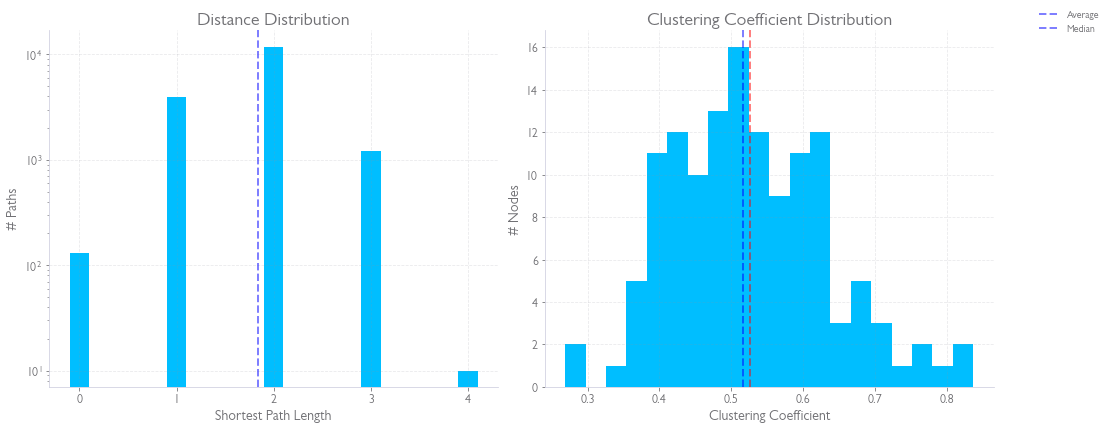

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))



figures['aggregated_path_lenght_distribution'] = fig
plot_network_clustering(G_network, ax1, ax2, with_network=False, print_labels=False)
plot_path_length_distribution(G_network, fig, ax1, log_scales=(False, True), width=0.2)

dviz.add_legend(fig,[ax1,ax2], on_fig=True)
figures['aggregated_APL_CC'] = fig

## In search of the small world effect

Abbiamo visto come la APL è molto bassa mentre l'avg. clustering è molto alto.<br>
Potremmo dunque concludere che la nostra rete presenta lo small world effect.<br>
In realtà questo effetto è un qualcosa di relativo e dipende dalla dimensione (n nodi e n archi) e connettività della rete.

Possiamo ragionevolmente aspettarci che in reti piccole e altamente connesse la APL sia bassa ed il clustering alto.<br>
Per verificare con più accuratezza e robustezza, procediamo utilizzando la metodologia basata sul *null model*.<br>
https://www.sciencedirect.com/science/article/pii/B9780124079083000108

In [44]:
import json


def smallworld_omega(G, n_rewiring=1, nrand=10, seed=None, save_on_disk=False, save_every_iter=10, precomputed=False):
    # Compute the mean clustering coefficient and average shortest path length
    # for an equivalent random graph
    rand_metrics = {"C": [], "L": []}
    if not precomputed:
        with open('smallworld.json', 'w') as jf:
            for i in range(nrand):
                Grand = nxa.smallworld.random_reference(G, niter=n_rewiring, seed=seed+i)
                Glatt = nxa.smallworld.lattice_reference(G, niter=n_rewiring, seed=seed+i)

                rand_metrics["C"].append(nx.transitivity(Glatt))
                rand_metrics["L"].append(nx.average_shortest_path_length(Grand))
                if (i % save_every_iter or i+1== nrand) and save_on_disk:
                    jf.seek(0) # overwrite file content
                    json.dump(rand_metrics, jf)
                       
    else: # read already pre computed values
        with open('smallworld.json', 'r') as jf:
            rand_metrics = json.load(jf)

    C = nx.transitivity(G)
    L = nx.average_shortest_path_length(G)
    Cl = np.mean(rand_metrics["C"])
    Lr = np.mean(rand_metrics["L"])

    omega = (Lr / L) - (C / Cl)
    emp_metrics = {'C': C, 'L': L}
    return omega, emp_metrics, rand_metrics

omega, emp_metrics, rand_metrics = smallworld_omega(G_network, nrand=network_data['omega_n_sims'], seed=RND_SEED, save_every_iter=10, save_on_disk=True)


KeyError: 'omega_n_sims'

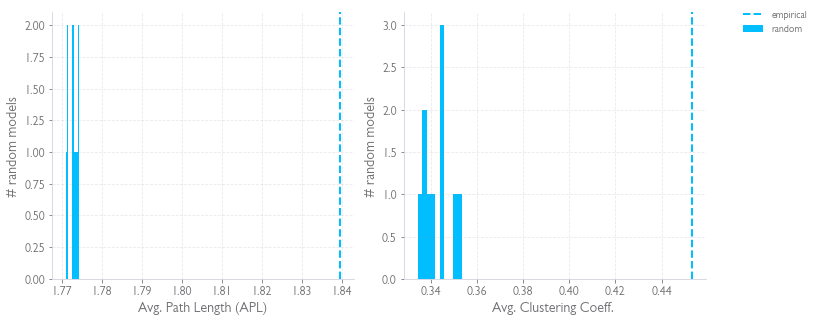

In [45]:
#print(f"sigma coeff: {sigma}; omega coeff. {omega}")

omega, emp_metrics, rand_metrics = smallworld_omega(G_network, nrand=1434, seed=RND_SEED, precomputed=True)
fig, axes = plt.subplots(1,2, figsize=(10,4.5))

axes[0].hist(rand_metrics['L'], bins=10, label='random')
axes[0].axvline(x=emp_metrics['L'], label='empirical', linestyle="--")
axes[0].set(xlabel="Avg. Path Length (APL)", ylabel='# random models')

axes[1].hist(rand_metrics['C'], bins=10, label='random')
axes[1].axvline(x=emp_metrics['C'], label='empirical',linestyle="--")
axes[1].set(xlabel="Avg. Clustering Coeff. ", ylabel='# random models')

dviz.add_legend(fig, axes, on_fig=True)

figures['aggregated_small_world_random_models'] = fig

# Network Robustness

TODO:

1. mostrare che inizialmente la rete possiede una singola componente
2. mostrare la variazione della dimensione della giant component e del n di componenti che si formano alla rimozione dei nodi:
* rimozione dei nodi in un regime random
* rimozione dei nodi in un regime "mirato", esisto nodi target? magari in base agli attributi?
3. comparazione tra i risultati ottenuti e quelli di un random graph (watts strogatz magari)

In [ ]:
def plot_bar_components(G, ax, *mpl_args, **mpl_kwargs):
    components_label = []
    components_count = []
    comp_nbr = 1 # number of the component (some sort of an index)
    for component in nx.connected_components(G):
        comp_name = "Component " + str(comp_nbr)
        components_label.insert(0, comp_name)
        components_count.insert(0, len(component))
        comp_nbr += 1
    components_label.reverse()
    components_count.reverse()
    # Bar Plot
    ax.set_ylabel("# Nodes")
    ax.bar(components_label, components_count, **mpl_kwargs)

def my_contains(lista, element):
    for el in lista:
        if el == element:
            return True
    return False

def plot_lcc_nodes(G, lcc_nodes, ax):
    # ax1
    cmap = palette.mpl_colormap
    node_colors = []
    for node in G.nodes:
        if my_contains(lcc_nodes, node):
            node_colors.insert(0, cmap(0.9))
        else:
            node_colors.insert(0, cmap(0.1))
    node_colors.reverse()
    nx.draw_kamada_kawai(G, node_color=node_colors, ax=ax, **network_options)

Partiamo con analizzare le componenti connesse della rete. Data l'elevata densità e la topologia del grafo che tende ad un grafo regolare $K_{131}$ ci aspettiamo poche componenti connesse, al limite solo una singola giant component. 

In [ ]:
def remove_nodes(G, delete_percent=.5, rnd_seed=123456):
    n_nodes = len(G.nodes)
    n_to_remove = int(n_nodes*delete_percent)

    rng = np.random.default_rng(rnd_seed)
    to_remove = rng.choice(G.nodes, n_to_remove, replace=False)
    

    decimated_G = G.copy()
    decimated_G.remove_nodes_from(to_remove)

    return  decimated_G# return a node decimated copy


def get_largest_component_size(G):
    return len(max(nx.connected_components(G), key=len))

In [ ]:
largest_cc_size = get_largest_component_size(G_network)
n_cc = nx.number_connected_components(G_network)

In [ ]:
print(f"Number of connected components: {n_cc}")
print(f"Size of Largest Connected Component: {largest_cc_size}")

Number of connected components: 1
Size of Largest Connected Component: 131


#### random removal

In [ ]:
N_SIMS = network_data['n_sims']
n_cc = []
largest_cc = []

n_cc_complete = []
largest_cc_complete = []

def prob(G):
    nLCC = get_largest_component_size(G)
    return nLCC / len(G.nodes)

n_nodes = len(G_network.nodes)
graph_models = {'empirical': G_network,
                'watts strogatz': nx.newman_watts_strogatz_graph(n_nodes, 14, 0.5),
                'erdos-renyi ($p=0.01$)':nx.erdos_renyi_graph(n_nodes, 0.01),
                'erdos-renyi ($p=0.05$)':nx.erdos_renyi_graph(n_nodes, 0.05),
                'erdos-renyi ($p=0.1$)':nx.erdos_renyi_graph(n_nodes, 0.1)}

del_percentages = np.arange(0.0, 1.0, 0.01)

metrics = [("nlcc", get_largest_component_size), 
           ("ncc", nx.number_connected_components),
           ("P(LCC)", prob)]

import itertools

# init dict
#def simulate_robustness_removal(graph_models, metrics)
collected_metrics = {}
for model, metric in itertools.product(graph_models.keys(), [metric for metric,_ in metrics]):
    collected_metrics[(metric, model)] = []

# run sims and collect
for del_perc in del_percentages:
    for metric_name, metric_func in metrics:
        for model, graph in graph_models.items():      
            simulations = []
            for i in range(N_SIMS):
                # remove nodes
                decimated = remove_nodes(graph, del_perc, rnd_seed=RND_SEED+i)
                # collect metrics
                simulations.append(metric_func(decimated)) # collect metric over sim
                
            collected_metrics[metric_name, model].append(np.mean(simulations)) # avg metric over sims

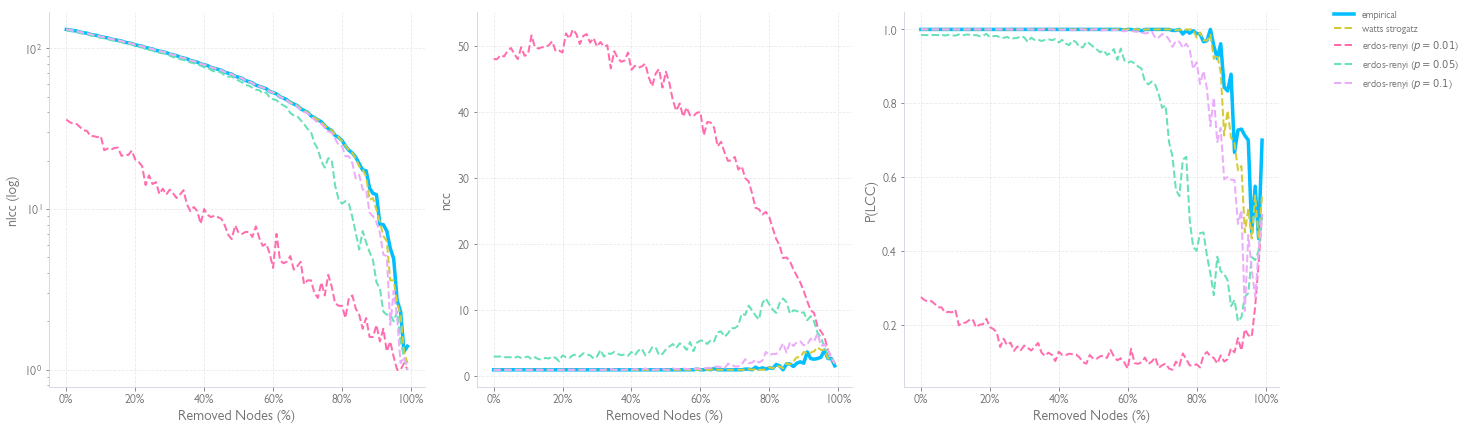

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
axes_dict = {'ncc': axes[1], 'nlcc': axes[0], 'P(LCC)': axes[2]}

for metric, model in collected_metrics:
    values = collected_metrics[metric, model]
    if model == 'empirical':
        axes_dict[metric].plot(del_percentages, values, linewidth=3.5, label=model)
    else:
        axes_dict[metric].plot(del_percentages, values, linestyle='--', label=model)
    axes_dict[metric].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    if metric == 'nlcc':
        dviz.set_axis(axes_dict[metric], xlabel='Removed Nodes (%)', ylabel=metric, log_scale=(False, True))
    else:
        dviz.set_axis(axes_dict[metric], xlabel='Removed Nodes (%)', ylabel=metric, log_scale=(False, False))
   
dviz.add_legend(fig, axes, on_fig=True)


figures['robusteness_analysis'] = fig

#### removal by centrality



come primo step analizziamo la centralità

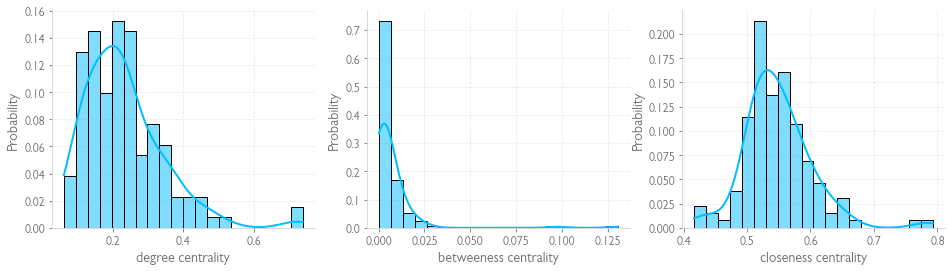

In [ ]:
centralities_metrics = [('degree', nxa.centrality.degree_centrality),
                        ('betweeness', nxa.centrality.betweenness_centrality),
                        ('closeness', nxa.centrality.closeness_centrality)]

fig, axes = plt.subplots(1,3, figsize=(16,4))

metrics_scores = {}

for (metric_name, metric), ax in zip(centralities_metrics, axes.ravel()):
    nodes, scores = zip(*metric(G_network).items())
    metrics_scores[metric_name] = scores 

    sns.histplot(scores, bins=20, ax=ax, stat='probability', kde=True)
    ax.set(xlabel=f"{metric_name} centrality")

figures['aggregated_centrality'] = fig

In [ ]:
def get_central_nodes(G, metric):
    nodes, scores = zip(*metric(G_network).items())
    sort_idxs = np.argsort(scores)[::-1]

    return np.array(nodes)[sort_idxs], np.array(scores)[sort_idxs]


def remove_nodes_by_score(G, metric, remove_percent=.5, use_weight=False, most_high_first=True):
    n_nodes = len(G.nodes)
    n_to_remove = int(n_nodes*remove_percent)

    # scoring 
    if use_weight:
        nodes, scores = zip(*G.degree(weight='weight')) #zip(*metric(G, weight='weight').items()) # expect that metric func return a dict {node:score}
    else:
        nodes, scores =  zip(*G.degree()) #zip(*metric(G).items()) # expect that metric func return a dict {node:score}
    if most_high_first:
        sort_idxs = np.argsort(scores)[::-1] # descending (most higher scored first)
    else:
         sort_idxs = np.argsort(scores) # ascending (most lowered scored first)
    
    # sorting & selection
    nodes = np.array(nodes)[sort_idxs]
    scores = np.array(scores)[sort_idxs]
    to_remove = nodes[:n_to_remove]  #to_remove = rng.choice(G.nodes, n_to_remove, replace=False)c
    
    # removing
    decimated_G = G.copy()
    decimated_G.remove_nodes_from(to_remove)

    return  decimated_G# return a node decimated copy




#### removal by attribute


In [ ]:
def remove_nodes_by_attribute(G, attribute, remove_percent=.5, oldest_first=True):
    n_nodes = len(G.nodes)
    n_to_remove = int(n_nodes*remove_percent)

    # scoring
    nodes, scores = zip(*nx.function.get_node_attributes(G, attribute).items())
    
    # sorting & selection
    if oldest_first:
        sort_idxs = np.argsort(scores)[::-1] # descending (most higher scored first)
    else:
         sort_idxs = np.argsort(scores) # ascending (most lowered scored first)
    
    # sorting & selection
    nodes = np.array(nodes)[sort_idxs]
    scores = np.array(scores)[sort_idxs]
    to_remove = nodes[:n_to_remove]  #to_remove = rng.choice(G.nodes, n_to_remove, replace=False)c
    
    # removing
    decimated_G = G.copy()
    decimated_G.remove_nodes_from(to_remove)

    return  decimated_G# return a node decimated copy

In [ ]:
N_SIMS = network_data['n_sims']


def prob(G):
    nLCC = get_largest_component_size(G)
    return nLCC / len(G.nodes)

n_nodes = len(G_network.nodes)
graph_models = {'empirical': G_network}

del_percentages = np.arange(0.0, 1.0, 0.01)

metrics = [("nlcc", get_largest_component_size), 
           ("ncc", nx.number_connected_components),
           ("p_inf", prob)]

# init dict
#def simulate_robustness_removal(graph_models, metrics)
collected_metrics = {}
for model, metric in itertools.product(['RR','RC', 'RCW','RA (oldest)', 'RA (youngest)'], [metric for metric,_ in metrics]):
    collected_metrics[(metric, model)] = []

# run sims and collect
for del_perc in del_percentages:
    for model, graph in graph_models.items():
        for metric_name, metric_func in metrics:     
            # Random removal strategy 
            simulations = []
            for i in range(N_SIMS):
                # remove nodes
                decimated_by_RR= remove_nodes(graph, del_perc, rnd_seed=RND_SEED+i)
                # collect metrics
                simulations.append(metric_func(decimated_by_RR)) # collect metric over sim
            collected_metrics[metric_name, 'RR'].append(np.mean(simulations)) # avg metric over sims
            
            # Removal by centrality strategy weighted
            decimated_by_RC = remove_nodes_by_score(graph, nxa.centrality.degree_centrality, del_perc, use_weight=True)
            metric_value = metric_func(decimated_by_RC)
            collected_metrics[metric_name, 'RCW'].append(metric_value)

            # Removal by centrality strategy
            decimated_by_RC = remove_nodes_by_score(graph, nxa.centrality.degree_centrality, del_perc,)
            metric_value = metric_func(decimated_by_RC)
            collected_metrics[metric_name, 'RC'].append(metric_value)

            # Removal by attributes strategy
            decimated_by_RA_oldest = remove_nodes_by_attribute(graph, 'age(days)', del_perc)
            decimated_by_RA_youngest = remove_nodes_by_attribute(graph, 'age(days)', del_perc, oldest_first=False)
            metric_value_oldest = metric_func(decimated_by_RA_oldest)
            metric_value_youngest = metric_func(decimated_by_RA_youngest)
            collected_metrics[metric_name, 'RA (oldest)'].append(metric_value_oldest)
            collected_metrics[metric_name, 'RA (youngest)'].append(metric_value_youngest)

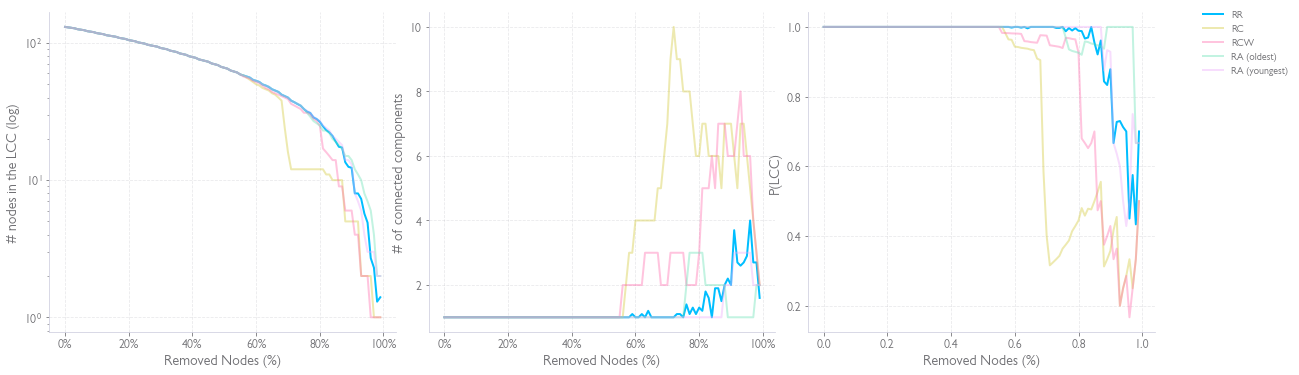

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes_dict = {'ncc': axes[1], 'nlcc': axes[0], 'p_inf':axes[2]}

for metric, strategy in collected_metrics:
    values = collected_metrics[metric, strategy]
    if strategy == 'RR':
        axes_dict[metric].plot(del_percentages, values, label=strategy)
    else:
        axes_dict[metric].plot(del_percentages, values, alpha=0.4, label=strategy)

dviz.add_legend(fig,axes, on_fig=True)
axes[0].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
axes[1].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
dviz.set_axis(axes[1], xlabel='Removed Nodes (%)', ylabel='# of connected components', )
dviz.set_axis(axes[0], xlabel='Removed Nodes (%)', ylabel='# nodes in the LCC',log_scale=(False, True))
dviz.set_axis(axes[2], xlabel='Removed Nodes (%)', ylabel='P(LCC)')


figures['robusteness_strategies_comparison'] = fig

## Network Degree Correlation

Questo è un commento sulla sezione

In [ ]:
def calculate_degree_correlation(G):
  # Funzione di correlazione degree
  n_degree = nx.average_neighbor_degree(G)
  # prendo per ogni nodo il suo valore
  nodes = list(n_degree.keys())
  values = list(n_degree.values())
  # Calcolo per ogni nodo i propri degree
  k_degrees = []
  for i in n_degree.keys():
      k = len([n for n in G.neighbors(i)])
      k_degrees.append(k)
  # Limite max di vicini (per il grafico)
  kmax = max(k_degrees) + 1
  result = np.zeros((kmax, 2))
  for k in range(0, kmax):
      knn_sum = 0
      cont = 0
      knn_avg = 0
      # Raggruppo tutti i k_degree in base ai vari k trovati (raggruppo per k crescente)
      for (node, ndegree, k_node) in zip(nodes, values, k_degrees):
          if k_node == k:
              knn_sum += ndegree
              cont +=1
      if cont > 0:
          knn_avg = knn_sum / cont
      result[k][0] = k
      result[k][1] = knn_avg
  return result[np.where(result[:, 1] != 0)[0]] # Ritorno solo i valori che hanno knn != 0, evita che il plot sia basato molto sugli outliners = 0

# fz_poly1d è il risultato di un np.polyfit(...)
def poly_coeff(fz_poly1d):
  poly_function = np.poly1d(fz_poly1d)
  return poly_function, float(str(poly_function).split(" ")[1]) # mi tiro fuori il coefficiente davanti alla x del polinomio

def print_dc_type(degree_correlation):
  # Indicazione se la rete è assortativa, neutrale o disassortativa
  _, coeff = poly_coeff(np.polyfit(degree_correlation[:, 0], degree_correlation[:, 1], 1))
  # Tutti i valori compresi fra questi 2 coefficienti indicano una rete neutrale
  print("Network Degree Correlation Coefficient:", coeff)
  network_type = "Neutral"
  if coeff >= ass_min_coeff:
    network_type = "Assortative"
  elif coeff <= disass_min_coeff:
    network_type = "Disassortative"
  print("Network is", network_type)

def plot_degree_correlation(degree_correlation, figure, ax, *mpl_args, **mpl_kwargs):
  # Bisogna solo fare attenzione agli outliner!! Se abbiamo molti valori di k funziona 'bene', in caso contrario può dipendere molto su k=0
  # risolto se non consideriamo k=0 se knn(0) = 0 (ovvero come stiamo facendo ora, riga 29 nella funzione qua sopra: calculate_degree_correlation)
  ################################################
  ##     TODO CONTROLLARE SE HA SENSO FARLA     ##
  ################################################
  # INOLTRE CONTROLLARE SE è CORRETTO SCRIVERE NELLA LABEL K^-COEFF, MI SEMBRA FACESSE COSì NELLE SLIDE
  # MA MEGLIO DARCI UNA OCCHIATA PER EVITARE DI SCRIVERE/PLOTTARE SCEMENZE
  p, coeff = poly_coeff(np.polyfit(degree_correlation[:, 0], degree_correlation[:, 1], 1))
  nx.assortativity.degree_pearson_correlation_coefficient(G_network)

  ax.scatter(degree_correlation[:, 0], degree_correlation[:, 1], **mpl_kwargs)
  ax.plot(degree_correlation[:, 0], p(degree_correlation[:, 0]), "b--", alpha=0.75, label= "k^"+"{:0.3f}".format(coeff), **mpl_kwargs)
  
  ax.set_xlabel("Degree (k)")
  ax.set_ylabel("K neighbours degree Knn(k)")
  ax.set_title("Degree Assortativity")
  ax.legend()

In [ ]:
g_degree_correlation = calculate_degree_correlation(G_network)
print_dc_type(g_degree_correlation)

Network Degree Correlation Coefficient: -0.06421
Network is Neutral


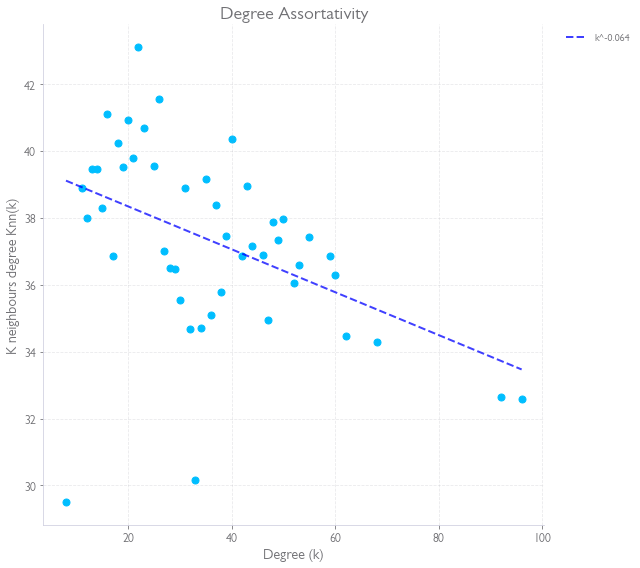

In [ ]:
fig, ax = plt.subplots(figsize = (9, 8))
plot_degree_correlation(g_degree_correlation, fig, ax)
dviz.add_legend(fig, ax)

figures['aggregated_assortativity'] = fig

## Network Communities

Questo è un commento sulla sezione

In [ ]:
# density = m / n*(n-1) con n = nodi e m = archi, per grafi indiretti è 2m
import community

def community_density(G, communities):
    t_communities = [(n, cid) for (n, cid) in communities.items()]
    densities = []
    for community_id in range(0, max([cid for (_, cid) in t_communities]) + 1):
        # prendo nodi della community attuale
        current_community = [n for (n, c_id) in t_communities if c_id == community_id]
        # calcolo nodi e archi della community
        comm_nodes = len(current_community)
        comm_archs = 0
        # Cerco fra ogni coppia di nodi della componente attuale se c'è un arco fra di loro
        for n1 in current_community:
            for n2 in current_community:
                if n1 != n2:
                    if G.has_edge(n1, n2):
                        comm_archs +=1
        # Calcolo densità con la formula scritta sopra
        density = comm_archs / (( comm_nodes * (comm_nodes - 1) ) + 1) #correzione di laplace per evitare division by zero
        densities.insert(0, (community_id, float("{:0.2f}".format(density))) )
    densities.reverse()
    return densities

def plot_communities_density(G, partitions, densities, ax1, ax2, plot_labels=False, *mpl_args, **mpl_kwargs):
    cmap = palette.mpl_colormap
    # ax1
    pos = nx.kamada_kawai_layout(G)  # compute graph layout
    nx.draw_networkx_nodes(G, pos,ax=ax1, cmap=cmap, node_color=list(partitions.values()), **node_options)
    if plot_labels:
        nx.draw_networkx_labels(G,pos,ax=ax1, **label_options)
    nx.draw_networkx_edges(G, pos,ax=ax1, **edge_options)
    ax1.grid() # non voglio avere la grid con il grafo

    # ax2
    dens_idxs = [idx for (idx, _) in densities]
    dens_values = [density for (_, density) in densities]
    xint = range(0, math.ceil(max(dens_idxs)) + 1)
    norm = plt.Normalize(0, max([key for key, _ in densities]))
    for den_id, den_val in zip(dens_idxs, dens_values):
        p_color = cmap(norm(den_id))
        ax2.plot(den_id, den_val, 'o', markersize=15, color=p_color, **mpl_kwargs)
    ax2.set_xticks(xint)
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_xlabel("Community Index")
    ax2.set_ylabel("Community Density")

In [ ]:
partitions = community.best_partition(G_network)
densities = community_density(G_network, partitions)

In [ ]:
import itertools
from collections import defaultdict
import pandas as pd

# Compute community partitions over days
# first day
partitions = community.best_partition(G_network, weight='weight')
community_table = pd.DataFrame.from_dict(partitions, orient='index', columns=['day1'])

for i, snapshot in enumerate(Gs_cut[1:], start=2):
    partitions = community.best_partition(snapshot, weight='weight')
    community_table[f"day#{i}"] = pd.Series(partitions)

# split cluster assignemnts in periods
period1 = community_table.iloc[:,0:11]
period2 = community_table.iloc[:,11:21]
period3 = community_table.iloc[:,21:31]
period4 = community_table.iloc[:,31:41]

# get cluster assignment (as most frequent) for each ant over the entire period 
period1 = period1.mode(axis='columns')[0]
period2 = period2.mode(axis='columns')[0]
period3 = period3.mode(axis='columns')[0]
period4 = period4.mode(axis='columns')[0]

# group ants by cluster memberships
clusters_period1 = period1.value_counts()
clusters_period2 = period2.value_counts()
clusters_period3 = period3.value_counts()
clusters_period4 = period4.value_counts()

periods = [period1, period2, period3, period4]


# compute cluster membership for each ants
clusters_periods = []

for i, period in enumerate(periods):
    clusters_period = []

    for cluster_idx in period.dropna().unique(): # for each cluster idx found in the period
        cluster_label = f"p{i}-c{int(cluster_idx)}" # concatenation
        values = set(period[period == cluster_idx].index.values) # get ants of the right cluster_idx and trasform pd.series to set
        clusters_period.append({int(cluster_idx):values})
    clusters_periods.append(clusters_period)


# compute links flow between two consecutive periods
labels = set()
flows = []
for i, (current_period, next_period) in enumerate(zip(clusters_periods, clusters_periods[1:]),start=1): # loop trough adjacent periods
    for cluster_current, cluster_next in itertools.product(current_period, next_period): # every possible pairs between current period clusters and clusters of the next one
        curr_cluster_idx = next(iter(cluster_current))
        next_cluster_idx = next(iter(cluster_next))
        
        # each cluster must have a unique label over periods -> concatenate period and cluster index togheter
        curr_label = f"p{i}-{curr_cluster_idx}"
        next_label = f"p{i+1}-{next_cluster_idx}"

        labels.add(curr_label)
        labels.add(next_label)

        curr_cluster = cluster_current[curr_cluster_idx]
        next_cluster = cluster_next[next_cluster_idx]
        common_ants= len(curr_cluster.intersection(next_cluster))
        
        flows.append((curr_label, next_label , common_ants))

        #print(f"p{i}-{curr_label} --> p{i+1}-{next_label} ::: {common}")

# prepare data for plotly sankey
labels_idx = {k:v for v,k in enumerate(list(labels))} # get indeces

sources = []
targets = []
values = []

for source, target, flow in flows:
    sources.append(labels_idx[source])
    targets.append(labels_idx[target])
    values.append(flow)


In [ ]:
import plotly.graph_objects as go

node = dict(pad = 10,
            thickness = 25,
            line = dict(color = "#00BEFF", width = .5),
            label = [f"Group {int(id[-1])+1}" for id in list(labels)],
            color = "#00BEFF")

link = dict(source = sources, target = targets, value = values, color='rgba(50, 190, 255, 0.25)')
data = go.Sankey(node=node, link = link, textfont=dict(family="Gill Sans MT", size=14),)

fig = go.Figure(data)

for x_coordinate, column_name in enumerate(["Period 1","Period 2","Period 3", "Period 4"]):
  fig.add_annotation(
          x=x_coordinate,
          y=1.1,
          xref="x",
          yref="paper",
          text=column_name,
          showarrow=False,
          font=dict(
              family="Gill Sans MT",
              size=18,
              color="black"
              ),
          align="center",
          )

fig.update_layout( 
  xaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  },
  yaxis={
  'showgrid': False, # thin lines in the background
  'zeroline': False, # thick line at x=0
  'visible': False,  # numbers below
  }, plot_bgcolor='rgba(0,0,0,0)', font_size=10)

fig.show()
fig.write_image("export/community_sankey.pdf",width=2600,height=800)
fig.write_image("export/community_sankey.png", width=2600,height=800, scale=2)

## Network Homophily

Questo è un commento sulla sezione

In [ ]:
''' 
    - G is a graph
    - char is the characteristic we want to study the homophily
'''
def homophily(G, char):
    n_ties = 0
    n_same_ties = 0
    for n1, n2 in G.edges():
        n1 = G_network.nodes[n1]
        n2 = G_network.nodes[n2]
        n_ties += 1 # C'è un edge, aggiungo un tie
        # Trovate le due caratteristiche, se sono uguali aumento n_same_ties (e se entrambi hanno la caratteristica)
        if(n1.get(char) != None and n2.get(char) != None and n1[char] == n2[char]):
            n_same_ties += 1
    return (n_same_ties / (n_ties + 1)) # Correzione di laplace x evitare division by zero

In [ ]:
# Test x avere a portata di mano i parametri su cui fare homophily
_, test_node_name = list(G_network.edges())[0]
test_node = G_network.nodes[test_node_name]
print(test_node)
print(test_node.get("age(days)"))

{'colony': 18, 'tag_id': 356, 'body_size': 183.199, 'age(days)': 40, 'nb_foraging_events': 0, 'group_period1': 'N', 'group_period2': 'N', 'group_period3': 'N', 'group_period4': 'N', 'visits_to_brood': 51.0, 'visits_to_nest_entrance': 0.363636, 'visits_to_rubbishpile': 0.909091, 'nb_interaction_nurses': 601.09091, 'nb_interaction_cleaners': 67.272727, 'nb_interaction_foragers': 18.818182, 'nb_interaction_queen': 26.45}
40


In [ ]:
# Stampo in base alla caratteristica che mi interessa, i risultati hanno range [0, 1]
print("G, observed proportion of same age:", "{:.3f}".format(homophily(G_network, "age(days)")))

G, observed proportion of same age: 0.071


## Export data

In [ ]:
from pathlib import Path
import string 

EXPORT_DIR = Path("export")

dviz.export_figures(EXPORT_DIR, figures, formatting_exceptions=['temporal_snapshots', 'temporal_sparsified_snapshots','random_nodes_neighbors'])

saving export/temporal_snapshots.pdf
saving export/temporal_snapshots.png
saving export/colony_survival_time.pdf
saving export/colony_survival_time.png
saving export/random_nodes_neighbors.pdf
saving export/random_nodes_neighbors.png
saving export/temporal_network_density_sparsification.pdf
saving export/temporal_network_density_sparsification.png
saving export/sparsification_density_qqplot.pdf
saving export/sparsification_density_qqplot.png
saving export/aggregated_network.pdf
saving export/aggregated_network.png
saving export/temporal_sparsified_snapshots.pdf
saving export/temporal_sparsified_snapshots.png
saving export/aggrgated_degree_distribution.pdf
saving export/aggrgated_degree_distribution.png
saving export/aggregated_path_lenght_distribution.pdf
saving export/aggregated_path_lenght_distribution.png
saving export/aggregated_APL_CC.pdf
saving export/aggregated_APL_CC.png
saving export/robusteness_analysis.pdf
saving export/robusteness_analysis.png
saving export/aggregated_centr

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cb57dfcf-e1ca-445d-8627-3e6f94f4b33f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>